In [10]:
# change the current dir so the sys know the .py modules
import os 
os.chdir('/home/jupyter/eye-tracking/python')

In [11]:
import json
import ijson
import base64
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cnn_utils import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [12]:
df = create_dataframe()
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.12549019607843137, 0.20392156862745098, 0...","[-0.04106040810056333, -0.2661677002711552, -0...","[0.20645009407383275, -0.25466045058369857, 0....","[-0.45034377387318564, 0.14983534577387492]"
1,"[[[0.3568627450980392, 0.4470588235294118, 0.6...","[-0.07226874514758119, -0.21267132333102778, -...","[0.1791002113662543, -0.1944043145408635, 0.21...","[0.14935064935064934, 0.44950603732162464]"
2,"[[[0.20784313725490197, 0.2823529411764706, 0....","[-0.05113651627800753, -0.2674861957086695, -0...","[0.21379589102346563, -0.24411637606250924, 0....","[-0.45034377387318564, -0.45060373216245886]"
3,"[[[0.20784313725490197, 0.2549019607843137, 0....","[-0.036367646064764614, -0.23934754171103256, ...","[0.2199010682250715, -0.21605467749028295, 0.2...","[-0.45034377387318564, 0.44950603732162464]"
4,"[[[0.19215686274509805, 0.25098039215686274, 0...","[-0.0797204637382114, -0.27350516572426786, -0...","[0.18218327924672018, -0.2482642153566159, 0.2...","[0.44957983193277307, -0.45060373216245886]"


In [13]:
x_train, x_validation, y_train, y_validation = create_train_validation(df)

In [14]:
# generate binary y labels
y_train_binary = create_binary_labels(y_train)
y_validation_binary = create_binary_labels(y_validation)

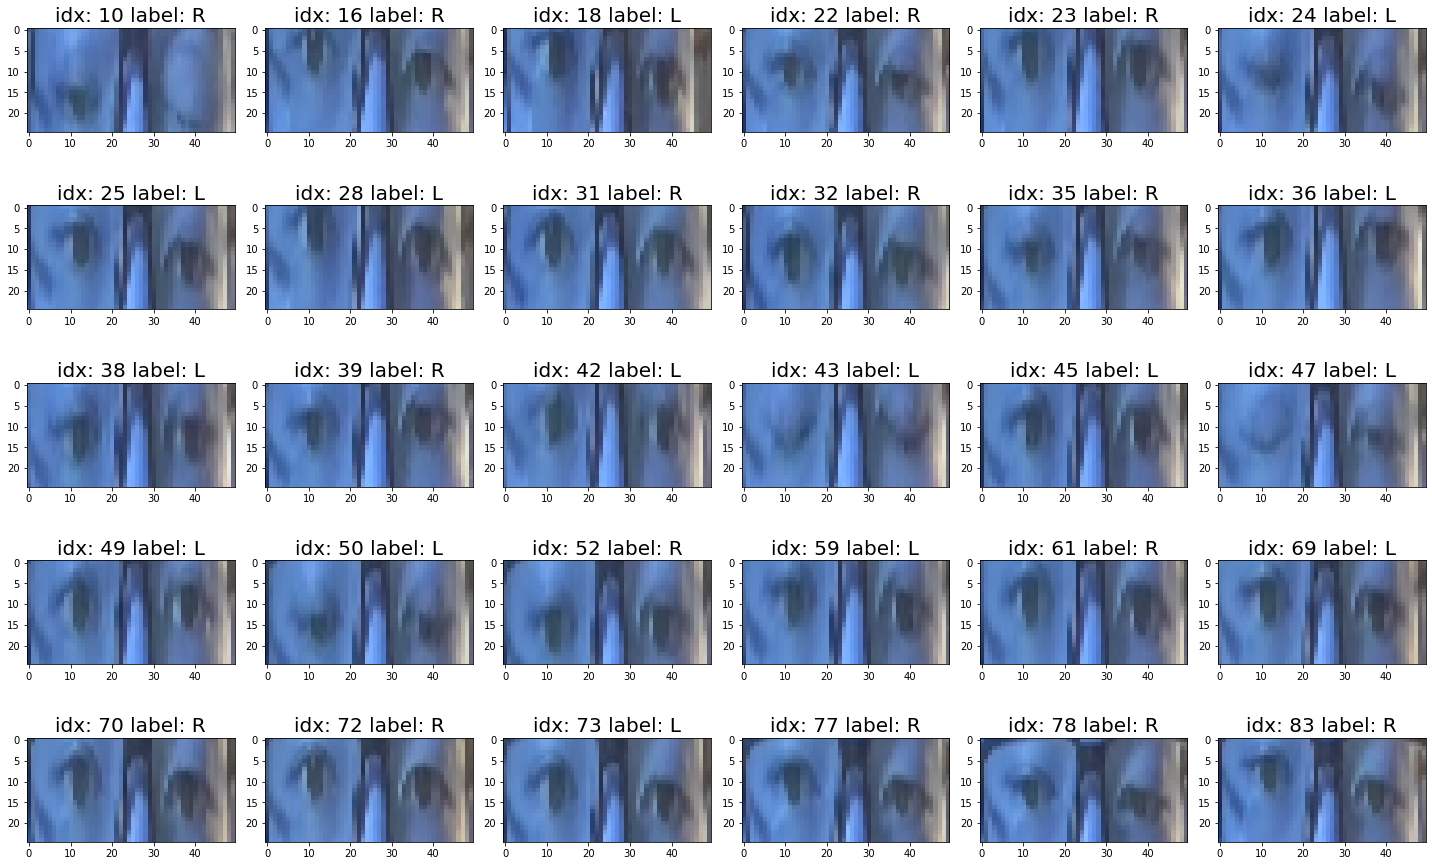

In [15]:
plot_eyeImages(x_train,y_train_binary)

## Simple CNN

In [20]:
IMG_WIDTH = x_train["eyeImage"].iloc[0].shape[1]
IMG_HEIGHT = x_train["eyeImage"].iloc[0].shape[0]


(25, 50, 3)

In [ ]:
eyeImage = tf.keras.layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
leftEye = tf.keras.layers.Input(shape=(12)) # requires the eye positions to be flattened to 1D
rightEye = tf.keras.layers.Input(shape=(12))

conv = tf.keras.layers.Conv2D(filters=20, kernel_size=5, strides=1, activation='relu', kernel_initializer='VarianceScaling')(eyeImage)
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(conv)
flat = tf.keras.layers.Flatten()(maxpool)
drop = tf.keras.layers.Dropout(rate=0.2)(flat)
concat = tf.keras.layers.concatenate([drop, leftEye, rightEye])
out = tf.keras.layers.Dense(units=2,activation="tanh",kernel_initializer='VarianceScaling')(concat)

simple_model = tf.keras.Model(inputs=[eyeImage, leftEye, rightEye], outputs=out)


### Compile the simple CNN

In [46]:
simple_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss = tf.keras.losses.MeanSquaredError())

simple_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 25, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 21, 46, 20)   1520        input_38[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 10, 23, 20)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 4600)         0           max_pooling2d_9[0][0]            
____________________________________________________________________________________________

In [22]:
tf.convert_to_tensor(x_train["eyeImage"].iloc[0])

<tf.Tensor 'Const:0' shape=(25, 50, 3) dtype=float64>

In [16]:
tf.data.Dataset.from_tensor_slices(        
    (
        tf.cast(training_df[features].values, tf.float32),
        tf.cast(training_df['target'].values, tf.int32)
    )
)

TypeError: Expected binary or unicode string, got array([[[0.20784314, 0.28235294, 0.41568627],
        [0.38823529, 0.53333333, 0.75294118],
        [0.38039216, 0.54901961, 0.79215686],
        ...,
        [0.37254902, 0.36470588, 0.37254902],
        [0.40392157, 0.4       , 0.41176471],
        [0.44313725, 0.45098039, 0.4745098 ]],

       [[0.22745098, 0.30588235, 0.44705882],
        [0.37254902, 0.5254902 , 0.75294118],
        [0.38039216, 0.54901961, 0.79607843],
        ...,
        [0.37254902, 0.36470588, 0.36470588],
        [0.38823529, 0.38431373, 0.38823529],
        [0.38823529, 0.39607843, 0.41176471]],

       [[0.24313725, 0.32156863, 0.46666667],
        [0.36862745, 0.52941176, 0.76078431],
        [0.37647059, 0.55294118, 0.8       ],
        ...,
        [0.37254902, 0.36078431, 0.35294118],
        [0.38039216, 0.37254902, 0.36862745],
        [0.34901961, 0.34901961, 0.36078431]],

       ...,

       [[0.09803922, 0.17647059, 0.42352941],
        [0.39607843, 0.55686275, 0.83137255],
        [0.4       , 0.58431373, 0.88235294],
        ...,
        [0.44705882, 0.43921569, 0.45882353],
        [0.40784314, 0.40392157, 0.42745098],
        [0.56470588, 0.58823529, 0.63137255]],

       [[0.08627451, 0.17254902, 0.41568627],
        [0.41568627, 0.56862745, 0.84313725],
        [0.4       , 0.58431373, 0.89411765],
        ...,
        [0.45490196, 0.44313725, 0.46666667],
        [0.40392157, 0.39215686, 0.41960784],
        [0.65882353, 0.68235294, 0.72941176]],

       [[0.09019608, 0.18431373, 0.42352941],
        [0.41568627, 0.56470588, 0.84313725],
        [0.4       , 0.59215686, 0.90588235],
        ...,
        [0.45490196, 0.44313725, 0.46666667],
        [0.38823529, 0.37647059, 0.4       ],
        [0.6745098 , 0.69411765, 0.74117647]]])